In [1]:
import os
import numpy as np
import cv2
import pandas as pd

# utils imports
import scipy.io as sio
import math
from math import cos, sin

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 
from torchvision import transforms
import torchvision
import torch.utils.model_zoo as model_zoo

import matplotlib.pyplot as plt

from PIL import Image, ImageFilter

# Utils

In [2]:
def get_list_from_filenames(file_path):
    # input:    relative path to .txt file with file names
    # output:   list of relative path names
    with open(file_path) as f:
        lines = f.read().splitlines()
    return lines

In [3]:
def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = sio.loadmat(mat_path)
    #print(f'this is the mat file fot sample {mat_path} : {mat}')
    pt2d = mat['pt2d']
    return pt2d

In [4]:
def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [5]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [6]:
def plot_pose_cube(img, yaw, pitch, roll, tdx=None, tdy=None, size=150.):
    # Input is a cv2 image
    # pose_params: (pitch, yaw, roll, tdx, tdy)
    # Where (tdx, tdy) is the translation of the face.
    # For pose we have [pitch yaw roll tdx tdy tdz scale_factor]

    p = pitch * np.pi / 180
    y = -(yaw * np.pi / 180)
    r = roll * np.pi / 180
    if tdx != None and tdy != None:
        face_x = tdx - 0.50 * size
        face_y = tdy - 0.50 * size
    else:
        height, width = img.shape[:2]
        face_x = width / 2 - 0.5 * size
        face_y = height / 2 - 0.5 * size

    x1 = size * (cos(y) * cos(r)) + face_x
    y1 = size * (cos(p) * sin(r) + cos(r) * sin(p) * sin(y)) + face_y
    x2 = size * (-cos(y) * sin(r)) + face_x
    y2 = size * (cos(p) * cos(r) - sin(p) * sin(y) * sin(r)) + face_y
    x3 = size * (sin(y)) + face_x
    y3 = size * (-cos(y) * sin(p)) + face_y

    # Draw base in red
    cv2.line(img, (int(face_x), int(face_y)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(face_x), int(face_y)), (int(x2),int(y2)),(0,0,255),3)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x1-face_x),int(y2+y1-face_y)),(0,0,255),3)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x2-face_x),int(y1+y2-face_y)),(0,0,255),3)
    # Draw pillars in blue
    cv2.line(img, (int(face_x), int(face_y)), (int(x3),int(y3)),(255,0,0),2)
    cv2.line(img, (int(x1), int(y1)), (int(x1+x3-face_x),int(y1+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2), int(y2)), (int(x2+x3-face_x),int(y2+y3-face_y)),(255,0,0),2)
    cv2.line(img, (int(x2+x1-face_x),int(y2+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(255,0,0),2)
    # Draw top in green
    cv2.line(img, (int(x3+x1-face_x),int(y3+y1-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x2+x3-face_x),int(y2+y3-face_y)), (int(x3+x1+x2-2*face_x),int(y3+y2+y1-2*face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x1-face_x),int(y3+y1-face_y)),(0,255,0),2)
    cv2.line(img, (int(x3), int(y3)), (int(x3+x2-face_x),int(y3+y2-face_y)),(0,255,0),2)

    return img

In [7]:
# ceate filesname file for dataset calss
def filter_samples(mat_path):
    '''
    neglect the samples with angel outside the angles range [-99, 99]
    paramters
    ---------
    mat_path : str, path for sample mat file that contains angel informations
    '''
    pose = get_ypr_from_mat(mat_path)
    pitch = pose[0] * 180 / np.pi
    yaw = pose[1] * 180 / np.pi
    roll = pose[2] * 180 / np.pi

    valid = (np.abs(pitch) > 99 or
           np.abs(yaw) > 99 or
           np.abs(roll) > 99)

    return valid

def find_filenams(imgs_folders, imgs_subfolders, filename_path):
    '''
    create file with the names of the training samples for 300W_LP dataset
    '''
    with open(f'{filename_path}/filename_list.txt', 'w') as names_file:
        valid_samples = 0
        for folder in imgs_subfolders:
            print(f'processing folder {folder}')
            for img_name in os.listdir(f'{imgs_folders}/{folder}') :
                # not image
                if not img_name.endswith('.jpg'): continue 
                file_name = f'{imgs_folders}/{folder}/{img_name.replace(".jpg","")}'
                # check tha angle range 
                if filter_samples(f'{file_name}.mat'): continue
                # save the sample
                names_file.write(f'{folder}/{img_name.replace(".jpg","")}\n')
                valid_samples += 1
                
        print(f'number of valid samples is {valid_samples}')

In [16]:
# creat the filenmae for 300W_LP Dataset without flipping dataset
SUBFOLDERS = ['AFW', 'HELEN', 'LFPW', 'IBUG']
imgs_folders = 'dataset/300W_LP'
filename_path = imgs_folders
find_filenams(imgs_folders, SUBFOLDERS, filename_path)

processing folder AFW
processing folder HELEN
processing folder LFPW
processing folder IBUG
number of valid samples is 61225


In [8]:
def write_to_file(file_path, data_list):
    with open(file_path,'w') as file:
        for item in data_list:
            file.write(item + '\n')

# split dataset
def split_dataset(filenames_list_path, training_pres = .9):
    # get file names
    filenames = get_list_from_filenames(filenames_list_path + '/filename_list.txt')
    # ranbomly shuffel dataset
    np.random.shuffle(filenames)
    num_training = int(len(filenames) * training_pres)
    print(f'number of training samples is {num_training}')
    train_dataset = filenames[:num_training]
    val_dataset = filenames[:num_training]
    # save splits
    write_to_file(filenames_list_path + '/filename_list_train.txt', train_dataset)
    write_to_file(filenames_list_path + '/filename_list_val.txt', val_dataset)    

In [14]:
split_dataset('dataset/300W_LP', training_pres = .9)

number of training samples is 55102


# DataSet

In [9]:
class Pose_300W_LP(Dataset):
    # Head pose from 300W-LP dataset
    def __init__(self, data_dir, filename_path, transform, augment=True, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.transform = transform
        self.augment = augment
        self.img_ext = img_ext
        self.annot_ext = annot_ext
        # get the images subfolder/name
        filename_list = get_list_from_filenames(filename_path)

        self.X_train = filename_list
        self.y_train = filename_list
        self.image_mode = image_mode
        self.length = len(filename_list)

    def __getitem__(self, index):
        # load image
        img = Image.open(f'{self.data_dir}/{self.X_train[index]}{self.img_ext}')
        img = img.convert(self.image_mode)
        # load lables
        mat_path = f'{self.data_dir}/{self.y_train[index]}{self.annot_ext}'

        # Crop the face loosely
        # get the image 2D facila points
        pt2d = get_pt2d_from_mat(mat_path)
        # find the face BBOX form facila points
        x_min = min(pt2d[0,:])
        y_min = min(pt2d[1,:])
        x_max = max(pt2d[0,:])
        y_max = max(pt2d[1,:])
        
        # adjust the face BBOX to more sutable size
        
        # k = 0.2 to 0.40 I the BBOX scaling factor
        # increase the size of the BBOX for, .12 * 2, .24 * 2
        # but the size for y_min is scaled more as the min point in 2D is eyes
        # fix k size during evaluation
        if self.augment: k = np.random.random_sample() * 0.2 + 0.2
        else : k = .3
        x_min -= 0.6 * k * abs(x_max - x_min)
        y_min -= 2 * k * abs(y_max - y_min) 
        x_max += 0.6 * k * abs(x_max - x_min)
        y_max += 0.6 * k * abs(y_max - y_min)
        img = img.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi

        # Flip Augmentaion
        rnd = np.random.random_sample()
        if rnd < 0.5 and self.augment:
            yaw = -yaw
            roll = -roll
            img = img.transpose(Image.FLIP_LEFT_RIGHT)

        # Blur Augmentaion
        rnd = np.random.random_sample()
        if rnd < 0.05 and self.augment:
            img = img.filter(ImageFilter.BLUR)

        # Bin values
        bins = np.array(range(-99, 102, 3)) # [-99, 99]
        # output: array(1*3) value[0, 66[, the number of the region each angle in
        binned_pose = np.digitize([yaw, pitch, roll], bins) - 1

        # Get target tensors
        labels = binned_pose
        angles = torch.FloatTensor([yaw, pitch, roll])

        if self.transform is not None:
            img = self.transform(img)
        else :
            img = transforms.ToTensor()(img)

        return img, labels, angles, self.X_train[index]

    def __len__(self):
        # 61,225 without flipping data
        return self.length

(240, 240, 3) <class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


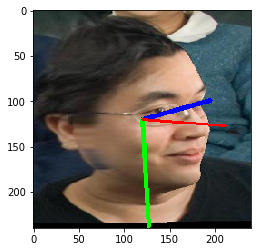

In [10]:
# test dataset
dataset = Pose_300W_LP(data_dir = 'dataset/300W_LP', filename_path = 'dataset/300W_LP/filename_list.txt', transform = None)
dl = DataLoader(dataset, batch_size=1, shuffle=True)

for img, dig_labels, exact_labels, img_path in dl:
    img, dig_labels, exact_labels, img_path = img[0], dig_labels[0], exact_labels[0], img_path[0]
    # draw the head pose estimation axes
    image = img.permute((1,2,0)).numpy()
    image = cv2.resize(image, dsize=(240, 240), interpolation=cv2.INTER_CUBIC)
    #image = cv2.imread(os.path.join('dataset/300W_LP', img_path + '.jpg'))
    print(image.shape, type(image))
    draw_axis(image, exact_labels[0], exact_labels[1], exact_labels[2], 
              tdx = image.shape[1] / 2, tdy= (image.shape[0]) / 2, size = image.shape[0]/2)
    plt.imshow(image)
    break

# Arch

In [11]:
class Hopenet(nn.Module):
    # Hopenet with 3 output layers for yaw, pitch and roll
    # Predicts Euler angles by binning and regression with the expected value
    def __init__(self, block, layers, num_bins):
        self.inplanes = 64
        super(Hopenet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc_yaw = nn.Linear(512 * block.expansion, num_bins)
        self.fc_pitch = nn.Linear(512 * block.expansion, num_bins)
        self.fc_roll = nn.Linear(512 * block.expansion, num_bins)

        # Vestigial layer from previous experiments
        self.fc_finetune = nn.Linear(512 * block.expansion + 3, 3)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        pre_yaw = self.fc_yaw(x)
        pre_pitch = self.fc_pitch(x)
        pre_roll = self.fc_roll(x)

        return pre_yaw, pre_pitch, pre_roll

# Train

## variables 

In [20]:
num_epochs = 25
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoints = 'checkpoints'
last_checkpoint = f'{checkpoints}/headpose_last.pth'
best_checkpoint = f'{checkpoints}/headpose_best.pth'
# create checkpoints file
os.makedirs(checkpoints, exist_ok=True)
# dataset variables
data_dir = 'dataset/300W_LP'
filename_list_train = f'{data_dir}/filename_list_train.txt'
filename_list_val = f'{data_dir}/filename_list_val.txt'

lr = 0.001

## Helper Functions

In [13]:
def get_ignored_params(model):
    # Generator function that yields ignored params.
    b = [model.conv1, model.bn1, model.fc_finetune]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            if 'bn' in module_name:
                module.eval()
            for name, param in module.named_parameters():
                yield param

def get_non_ignored_params(model):
    # Generator function that yields params that will be optimized.
    b = [model.layer1, model.layer2, model.layer3, model.layer4]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            if 'bn' in module_name:
                module.eval()
            for name, param in module.named_parameters():
                yield param

def get_fc_params(model):
    # Generator function that yields fc layer params.
    b = [model.fc_yaw, model.fc_pitch, model.fc_roll]
    for i in range(len(b)):
        for module_name, module in b[i].named_modules():
            for name, param in module.named_parameters():
                yield param

def load_filtered_state_dict(model, snapshot):
    # By user apaszke from discuss.pytorch.org
    model_dict = model.state_dict()
    snapshot = {k: v for k, v in snapshot.items() if k in model_dict}
    model_dict.update(snapshot)
    model.load_state_dict(model_dict)

In [14]:
# intialize model
# ResNet50 structure
model = Hopenet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 66)
model.to(device)

In [15]:
# load checkpoint
if os.path.exists(last_checkpoint):
    saved_state_dict = torch.load(args.snapshot)
    model.load_state_dict(saved_state_dict)
else:
    # load ImageNet weights
    load_filtered_state_dict(model, model_zoo.load_url(torchvision.models.resnet.model_urls['resnet50']))

In [17]:
# dataset transformer
transformations = transforms.Compose([transforms.Scale(240),
                                      transforms.RandomCrop(224), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# create training dataloader
pose_train = Pose_300W_LP(data_dir, filename_list_train, transform=transformations, augment=True)
train_loader = DataLoader(pose_train, batch_size=batch_size, shuffle=True, num_workers=4)

# create val dataloader
pose_val = Pose_300W_LP(data_dir, filename_list_val, transform=None, augment=False)
train_loader = DataLoader(pose_val, batch_size=batch_size, shuffle=False, num_workers=4)

C:\Users\eleza\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [21]:
# loss for softmax prediction
cls_criterion = nn.CrossEntropyLoss().to(device)
#loss of Regression fine tuning
reg_criterion = nn.MSELoss().to(device)

# optimizer, set three diffrent lr through the network
optimizer = torch.optim.Adam([{'params': get_ignored_params(model), 'lr': 0},
                              {'params': get_non_ignored_params(model), 'lr': lr},
                              {'params': get_fc_params(model), 'lr': lr * 5}],
                               lr = lr)

## training

In [22]:
def compute_cls_loss(criterion, pred, target, device):
    # move to device
    target = target.to(device)
    # compute loss
    cls_loss = criterion(pred, target)
    return loss

In [23]:
def compute_reg_loss(criterion, pred, target, device):
    # move to device
    target = target.to(device)
    # compute predected prop
    softmax = nn.Softmax().to(device)
    pred_prop = softmax(pred)
    # get regression value for proplities
    idx_tensor = torch.FloatTensor([idx for idx in range(66)]).to(device)
    reg_pred = torch.sum(pred_prop * idx_tensor) * 3 - 99 # [-99, 99]
    # compute reg loss
    reg_loss = criterion(reg_pred, target)
    return loss

In [ ]:
def train_epoch(model, train_loader, epoch_num, cls_criterion, reg_criterion, disp_every, device):
    # values to compute
    total_loss = 0
    total_acc_perAng = [0, 0, 0] # yaw, pitch, roll
    
    for i, (img, angles, bins_angles, img_name) in enumerate(train_loader):
        
        # pass image to the model
        pred_yaw, pred_pitch, pred_roll = model(img.to(device))
        
        # compute classification losses
        loss_cls_yaw = compute_cls_loss(cls_criterion, pred_yaw, bins_angles[:, 0], device)
        loss_cls_pitch = compute_cls_loss(cls_criterion, pred_pitch, bins_angles[:, 1], device)        
        loss_cls_roll = compute_cls_loss(cls_criterion, pred_roll, bins_angles[:, 2], device)
        
        # computer regression losses 
        loss_reg_yaw = compute_reg_loss(reg_criterion, pred_yaw, angles[0], device)
        loss_reg_pitch = compute_reg_loss(reg_criterion, pred_pitch, angles[1], device)        
        loss_reg_roll = compute_reg_loss(reg_criterion, pred_roll, angles[2], device)
        
        # total losses 
        loss_yaw = loss_cls_yaw + alpha * loss_reg_yaw
        loss_pitch = loss_cls_pitch + alpha * loss_reg_pitch        
        loss_roll = loss_cls_roll + alpha * loss_reg_roll
        
        # backprop and optimize 
        